# Prediction of the function development using RNNs and its comparsion with other NNs

In this work I would like to use various neural network models to predict future price of BTC based on various cryptocurrency prices.  

### Importing libraries

I am going to use tensorflow and other libraries.

In [46]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [47]:
import glob

In [48]:
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

#### parameters

In [49]:
RATIO_TO_PREDICT = "BTC-USD"
FUTURE_PERIOD_PREDICT = 2

## Loading data

#### Downloaded data
I downloaded dataset from: https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip. It contains 4 separate files with 5 columns for BTC, LTC, ETH and BCH. I am going to use only close price column. Code below extracts mecessary data from those files and creates pandas dataframe from it.

This code loops through ratios and loads the whole file into dataframe. Before adding that dataframe to our main dataframe which is called main_df we will drop unnecessary and only keep close price.

In [50]:
main_df = pd.DataFrame()

ratios = ["BTC-USD", "LTC-USD","ETH-USD","BCH-USD"]

for ratio in ratios:
    dataset = "crypto_data/"+ratio+".csv"
    df = pd.read_csv(dataset, names=["time","low","high","open","close","volume"])
    
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)
    
    df.set_index("time", inplace=True)
    df = df[[f"{ratio}_close"]]
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)


Because there are some NaN values we will get rid of them using code below.

In [51]:
main_df = main_df.dropna()

Here we can see how main_df. It contains 5 columns from which we will be using only close prices.

In [52]:
main_df

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
time,,,,
1528968720,6487.379883,96.660004,486.010010,870.859985
1528968780,6479.410156,96.570000,486.000000,870.099976
1528968840,6479.410156,96.500000,485.750000,870.789978
1528968900,6479.979980,96.389999,486.000000,870.000000
1528968960,6480.000000,96.519997,486.000000,869.989990
...,...,...,...,...
1535214960,6713.140137,58.020000,279.359985,531.479980
1535215020,6714.520020,58.009998,279.359985,531.479980
1535215080,6714.520020,58.020000,279.369995,531.469971


To have better idea what our main dataframe represents we can plot our 4 prices using matplotlib

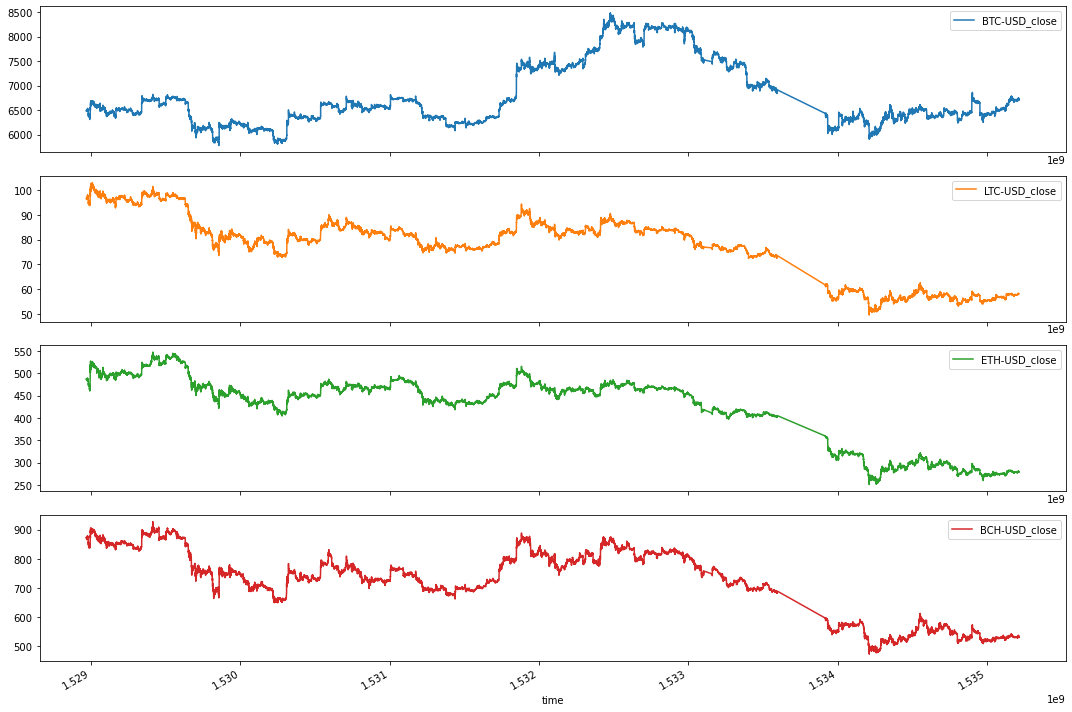

In [53]:
main_df.plot(subplots=True)
plt.tight_layout()
plt.show()

As we can see, there is a problematic part in our df in two thirds of the lenght.
I will cut the dataframe to exclude that data.

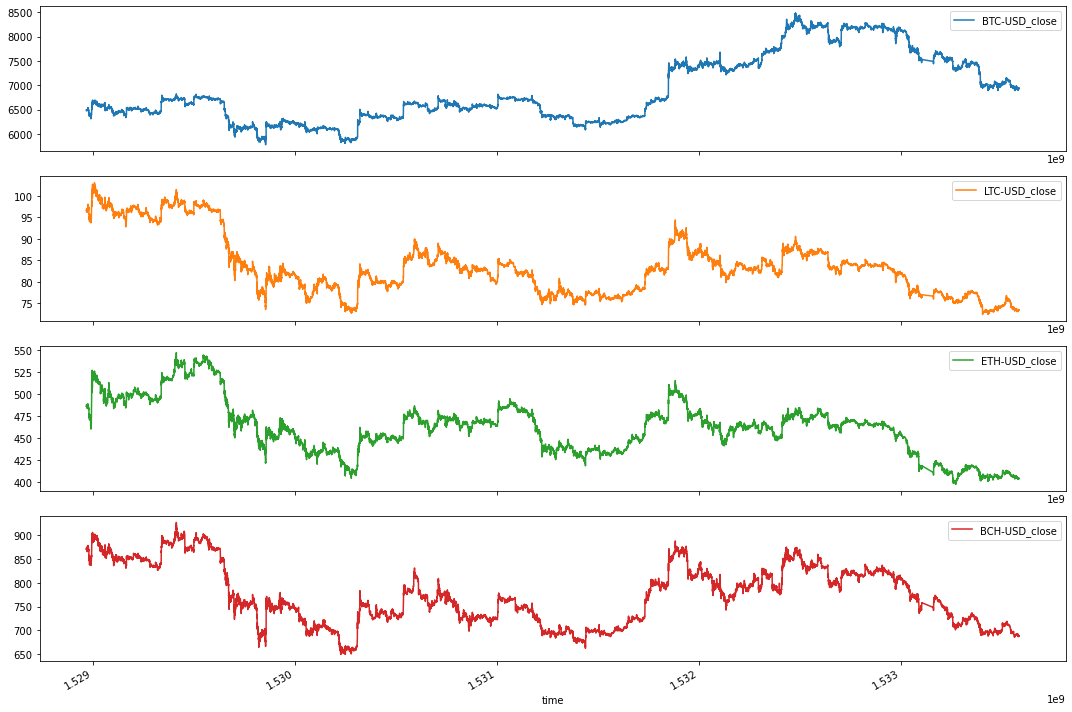

In [54]:
n = int(len(main_df)*0.78)
main_df = main_df[:n]
main_df.plot(subplots=True)
plt.tight_layout()
plt.show()

Another very useful function to use when exploring datasets is describe().

In [55]:
main_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,67171.000000,67171.000000,67171.000000,67171.000000
mean,6870.308763,83.741700,462.141509,774.064844
std,683.181276,6.889541,30.659425,62.814744
min,5778.109863,72.400002,397.299988,649.619995
25%,6350.629883,78.260002,439.820007,722.890015
50%,6638.160156,82.830002,464.010010,766.309998
75%,7417.705078,86.559998,476.429993,824.474976
max,8482.799805,103.040001,547.000000,927.000000


#### Created data

This part explores data  I have been collecting.

In [56]:
path = 'crypto_data/my_dataset_csv.csv'               

my_df = pd.read_csv(path)  
my_df = my_df.dropna()

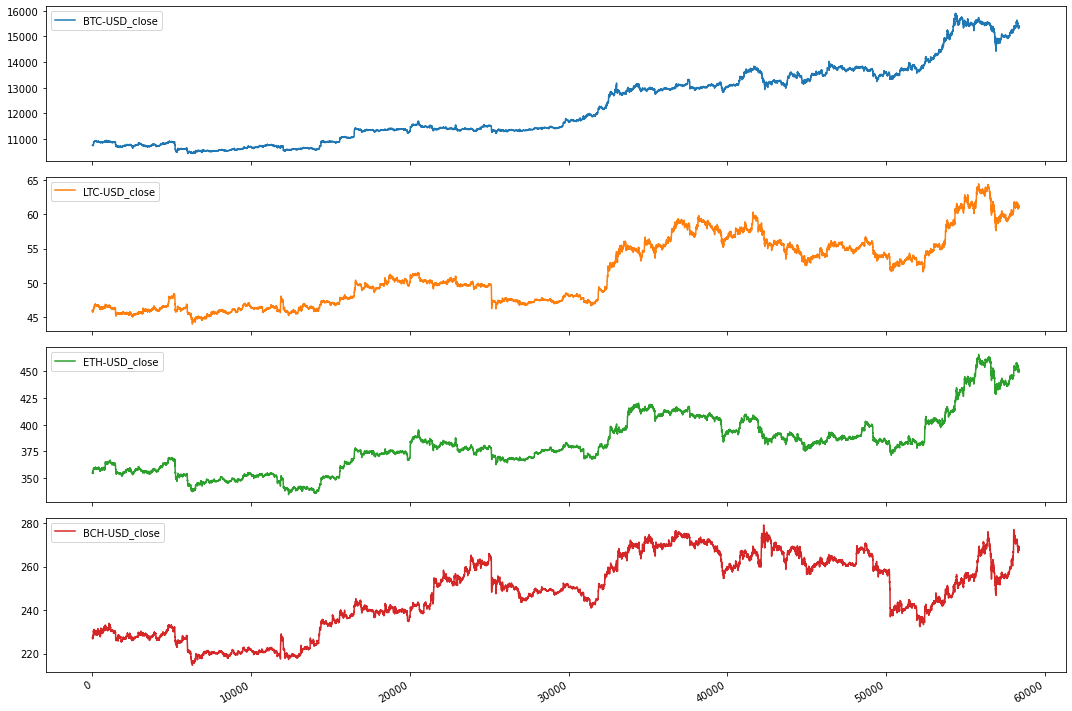

In [57]:
my_df.plot(subplots=True)
plt.tight_layout()
plt.show()

In [70]:
my_df = my_df.drop('Datetime', 1)

## Splitting data
It is common to split datasets into 3 parts. One is called training set and is uset for training our models. Another part is called validation set and after trainig we evaluate our model using this set and eventually change our model settings. After our model is done we will chceck results on thirs set which is calles test set. This last set is supposed to be uknown for our model so it should behave like "real world" data. We should pick model which does the best job with test set.

I will split main df into 3 parts with this ratio: (70%, 20%, 10%) train, validation, test.

In [71]:
def split_dataset(df):
    
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    return train_df, val_df, test_df

In [72]:
#column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = main_df.shape[1]

In [73]:
train_df_d, val_df_d, test_df_d = split_dataset(main_df)

In [74]:
train_df_my, val_df_my, test_df_my = split_dataset(my_df)

In [75]:
train_df_my

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
0,10756.69336,45.950085,355.052521,227.412643
1,10756.32324,45.935162,355.128204,227.445343
2,10756.91602,46.006992,355.125977,227.432785
3,10758.65234,45.928307,355.280060,227.488831
4,10756.71484,45.916527,355.288788,227.308319
...,...,...,...,...
38246,12941.99316,58.914696,406.035004,270.446655
38247,12942.03223,58.914402,406.036224,270.447601
38248,12942.03516,58.914402,406.036346,270.447601
38249,12974.98828,59.006432,406.702728,271.075073


## Normalizing data
Our model could work even without normalizing, but it improves training ability and performance. My data has different scales, for that reason I need to normalize it. I decided to use common technique called z-score point. 

To scale my dataframes with z-score point I am going to use sklearn library with StandardScaler().

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [77]:
train_df_d = pd.DataFrame(scaler.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler.fit_transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler.fit_transform(test_df_d),columns = test_df_d.columns)

In [78]:
train_df_my = pd.DataFrame(scaler.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler.fit_transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler.fit_transform(test_df_my),columns = test_df_my.columns)

In [79]:
train_df_my

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
0,-0.793513,-0.825818,-0.724952,-0.830751
1,-0.794013,-0.830423,-0.721157,-0.828737
2,-0.793213,-0.808257,-0.721268,-0.829510
3,-0.790867,-0.832539,-0.713542,-0.826058
4,-0.793484,-0.836174,-0.713104,-0.837177
...,...,...,...,...
36846,2.158766,3.174997,1.831480,1.819878
36847,2.158819,3.174906,1.831541,1.819936
36848,2.158823,3.174906,1.831547,1.819936
36849,2.203342,3.203306,1.864962,1.858585


##### Another posibility
###### Subtract the mean and divide by the standard deviation of each feature.


In [20]:
"""
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df
"""

'\ntrain_mean = train_df.mean()\ntrain_std = train_df.std()\n\ntrain_df = (train_df - train_mean) / train_std\nval_df = (val_df - train_mean) / train_std\ntest_df = (test_df - train_mean) / train_std\ntrain_df\n'

### Data windowing

Models will make predictions using part of data called windows. 
For now, class below holds some values and another functions will be added later.

In [80]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        # This part takes arguemntes and calculate window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        

        # Window size is equal to input width and shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # slice(0, i_w, None)
        
        # np.arange(5) -> array([0, 1, 2, 3, 4])
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Code below splits data inside window class into inputs and labels.
Inputs are data from which our model is supposed to predict label, 
which is the actual correct value.

In [81]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]   
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [82]:
w2 = WindowGenerator(input_width=10, label_width=1, shift=2,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d, label_columns=['BTC-USD_close'])
w2

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [11]
Label column name(s): ['BTC-USD_close']

In [83]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_d[:w2.total_window_size]),
                           np.array(train_df_d[100:100+w2.total_window_size]),
                           np.array(train_df_d[200:200+w2.total_window_size])])

In [84]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 12, 4)
Inputs shape: (3, 10, 4)
labels shape: (3, 1, 1)


In [85]:
example_window.shape

TensorShape([3, 12, 4])

Simple vizualization of the split window with function plot().

In [86]:
w2.example = example_inputs, example_labels

In [87]:
def plot(self, model=None, plot_col='BTC-USD_close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

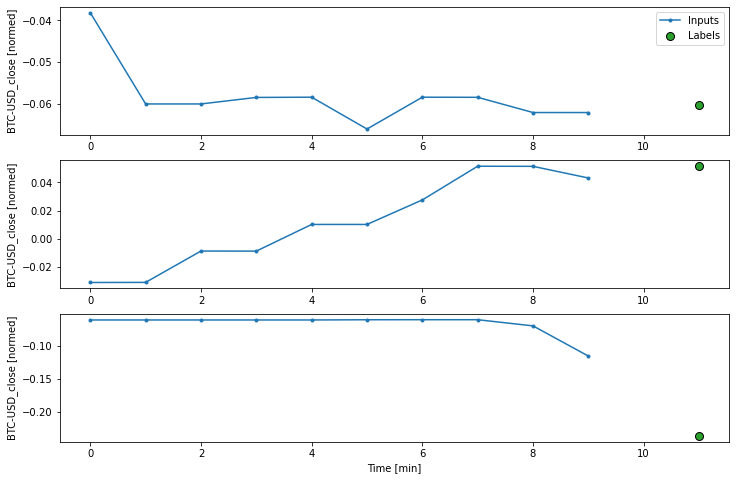

In [88]:
w2.plot()

#### Create dataset

Function below takes dataframe and converts it to tf.data.Dataset with (input_window, label_window) pairs.
First, we convert dataframe to np.array and then timeseries_dataset_from_array function converts it to dataset. 

In [90]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
    # very useful function which converts data to dataset (input_window, label_window) from array

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

### playground
playground is going to be deleted later. It is just for me to see some stuff.

In [110]:
def split_window_test(features):
    inputs = features[:, 10, :]   
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, 1, :]


    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, 10, None])
    labels.set_shape([None, 1, None])

    return inputs, labels

In [111]:
def make_dataset_test(data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=12,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
    # very useful function which converts data to dataset (input_window, label_window) from array

    #ds = ds.map(split_window_test)

    return ds

WindowGenerator.make_dataset = make_dataset

In [112]:
train_df.head(20)

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
time,,,,
1528968720,6487.379883,96.660004,486.010010,870.859985
1528968780,6479.410156,96.570000,486.000000,870.099976
1528968840,6479.410156,96.500000,485.750000,870.789978
1528968900,6479.979980,96.389999,486.000000,870.000000
1528968960,6480.000000,96.519997,486.000000,869.989990
1528969020,6477.220215,96.440002,485.989990,869.450012
1528969080,6480.000000,96.470001,485.989990,869.989990
1528969140,6479.990234,96.400002,485.989990,870.000000
1528969200,6478.660156,96.400002,485.989990,870.320007


In [113]:
ds = make_dataset_test(train_df)
ds

<BatchDataset shapes: (None, None, 4), types: tf.float32>

In [114]:
f = 0
for i in ds:
    f = f+1
    #print(i)

tf.Tensor(
[[[6487.38   96.66  486.01  870.86]
  [6479.41   96.57  486.    870.1 ]
  [6479.41   96.5   485.75  870.79]
  [6479.98   96.39  486.    870.  ]
  [6480.     96.52  486.    869.99]
  [6477.22   96.44  485.99  869.45]
  [6480.     96.47  485.99  869.99]
  [6479.99   96.4   485.99  870.  ]
  [6478.66   96.4   485.99  870.32]
  [6478.66   96.4   486.    870.65]
  [6479.34   96.4   486.    871.22]
  [6479.35   96.4   486.    871.88]]

 [[6479.41   96.57  486.    870.1 ]
  [6479.41   96.5   485.75  870.79]
  [6479.98   96.39  486.    870.  ]
  [6480.     96.52  486.    869.99]
  [6477.22   96.44  485.99  869.45]
  [6480.     96.47  485.99  869.99]
  [6479.99   96.4   485.99  870.  ]
  [6478.66   96.4   485.99  870.32]
  [6478.66   96.4   486.    870.65]
  [6479.34   96.4   486.    871.22]
  [6479.35   96.4   486.    871.88]
  [6479.99   96.45  486.    871.88]]

 [[6479.41   96.5   485.75  870.79]
  [6479.98   96.39  486.    870.  ]
  [6480.     96.52  486.    869.99]
  [6477.22   

In [115]:
f

1

#### end of this playground

To access data we add propertie below. Also standard example is added for plotting.

In [92]:
@property  # https://www.python-course.eu/python3_properties.php
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Define wide window

In [93]:
wide_window_d = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=['BTC-USD_close'])

In [94]:
wide_window_my = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=['BTC-USD_close'])

#### To compare prediction performances

In [95]:
val_performance = {}
performance = {}

## Models

In [96]:
from tensorflow.keras.models import load_model

class LoadedModel():
    def __init__(self, dir_name):
        self.model = load_model(dir_name)
        
    def eval_mod(self, window, verbose):
        res = self.model.evaluate(window, verbose=verbose)
        print("Loss:", res[0], "MAE:", res[1])
        
    def save_model(self, name):
        self.model.save("models_retrained\\"+ name +".model")
        
    def retrain_model(self, patience, epochs, window):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
        history = self.model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
        self.history = history
        

#### Training procedure
Because we will train more models let's create function which compiles and train desired model.

In [121]:
MAX_EPOCHS = 22

def compile_and_fit(model, window, patience=3):

    ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', restore_best_weights=True)

    # https://github.com/Jaewan-Yun/optimizer-visualization
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model
    opt = tf.optimizers.Adam()
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

To plot learning process there is a function below.

In [98]:
def plot_loss(history, graph_param):
    plt.plot(history.history[str(graph_param)], label=str(graph_param))
    plt.plot(history.history['val_'+ str(graph_param)], label='val_' + str(graph_param))
    plt.xlabel('Epoch')
    plt.ylabel(graph_param)
    plt.legend()
    plt.grid(True)

To save model I created function below.

In [167]:
def save_model(model, name):
    model.save("models_first\\"+ name +".model")
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#save
    """
    save(filepath, overwrite=True, include_optimizer=True, save_format=None,signatures=None, options=None)
    """

### Dense
This model takes defined number of timesteps and make prediction base on them at once.

In [100]:
CONV_WIDTH = 24   # 24 time steps
conv_window = WindowGenerator(
    input_width = CONV_WIDTH,
    label_width = 1,                       # one label value
    shift = FUTURE_PERIOD_PREDICT,         # two mins to the future
    train_df = train_df_d,
    val_df = val_df_d,
    test_df = test_df_d,
    label_columns = ["BTC-USD_close"])

conv_window

Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [25]
Label column name(s): ['BTC-USD_close']

Text(0.5, 1.0, 'Given 10 mins as input, predict 2 mins into the future.')

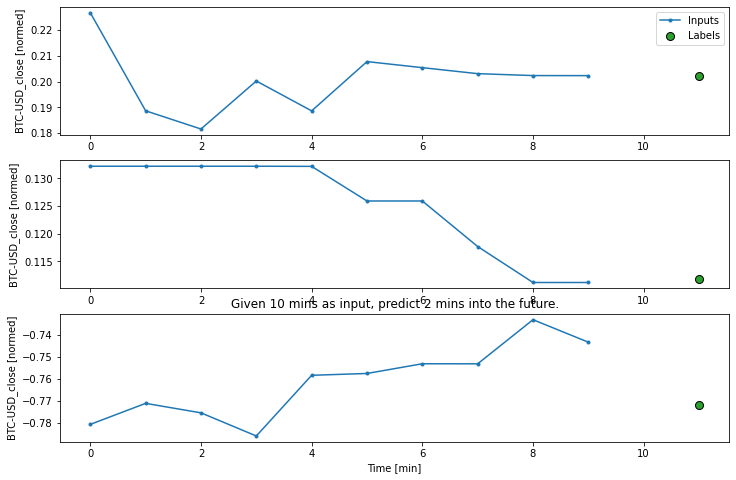

In [46]:
conv_window.plot()
plt.title("Given 10 mins as input, predict 2 mins into the future.")

In [47]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [48]:
conv_window.val

<MapDataset shapes: ((None, 10, 4), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [49]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 10, 4)
Output shape: (32, 1, 1)


In [50]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20
1469/1469 [==============================] - 5s 3ms/step - loss: 0.4730 - mean_absolute_error: 0.4906 - val_loss: 0.2840 - val_mean_absolute_error: 0.4168
Epoch 2/20
1469/1469 [==============================] - 6s 4ms/step - loss: 0.0696 - mean_absolute_error: 0.1698 - val_loss: 0.0746 - val_mean_absolute_error: 0.1820
Epoch 3/20
1469/1469 [==============================] - 6s 4ms/step - loss: 0.0106 - mean_absolute_error: 0.0585 - val_loss: 0.0240 - val_mean_absolute_error: 0.1101
Epoch 4/20
1469/1469 [==============================] - 5s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0350 - val_loss: 0.0125 - val_mean_absolute_error: 0.0794
Epoch 5/20
1469/1469 [==============================] - 5s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0273 - val_loss: 0.0090 - val_mean_absolute_error: 0.0669
Epoch 6/20
1469/1469 [==============================] - 5s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0242 - val_loss: 0.0076 - val_mean_absolute_error: 0.0620
Epoc

In [51]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

420/420 [==============================] - 1s 2ms/step - loss: 0.0042 - mean_absolute_error: 0.0464


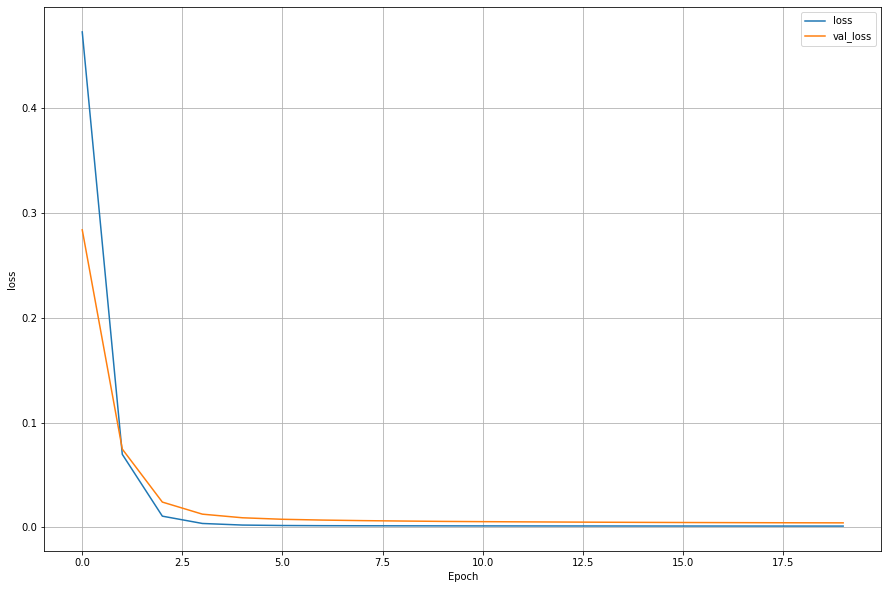

In [52]:
plot_loss(history, 'loss')

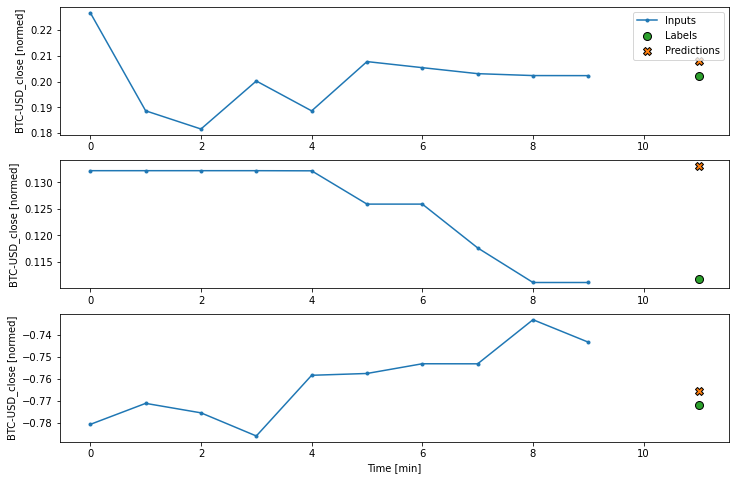

In [53]:
conv_window.plot(multi_step_dense)

In [54]:
save_model(multi_step_dense, "multi_step_dense")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models_third\multi_step_dense.model\assets


In [55]:
print('Input shape:', wide_window_d.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window_d.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 4)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,96], In[1]: [40,128] [Op:MatMul]


### Convolutional neural network


In [56]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [57]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/20
1469/1469 [==============================] - 5s 4ms/step - loss: 0.6911 - mean_absolute_error: 0.5818 - val_loss: 0.4602 - val_mean_absolute_error: 0.6020
Epoch 2/20
1469/1469 [==============================] - 5s 3ms/step - loss: 0.3666 - mean_absolute_error: 0.3894 - val_loss: 0.2247 - val_mean_absolute_error: 0.4274
Epoch 3/20
1469/1469 [==============================] - 5s 3ms/step - loss: 0.1895 - mean_absolute_error: 0.2715 - val_loss: 0.0965 - val_mean_absolute_error: 0.2714
Epoch 4/20
1469/1469 [==============================] - 4s 3ms/step - loss: 0.0756 - mean_absolute_error: 0.1660 - val_loss: 0.0320 - val_mean_absolute_error: 0.1437
Epoch 5/20
1469/1469 [==============================] - 4s 3ms/step - loss: 0.0180 - mean_absolute_error: 0.0851 - val_loss: 0.0120 - val_mean_absolute_error: 0.0804
Epoch 6/20
1469/1469 [==============================] - 4s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0484 - val_loss: 0.0082 - val_mean_absolute_error: 0.0657
Epoc

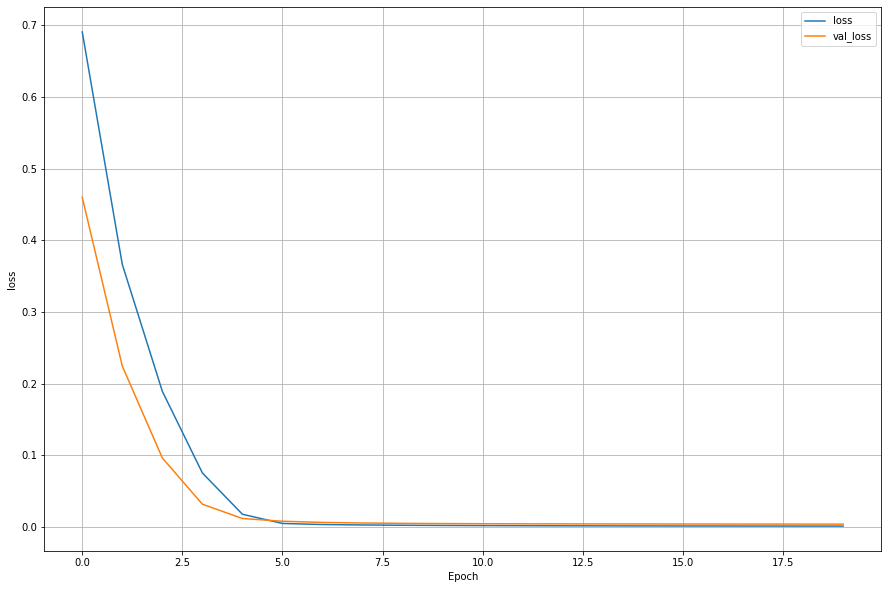

In [58]:
plot_loss(history, 'loss')

In [59]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

420/420 [==============================] - 1s 2ms/step - loss: 0.0042 - mean_absolute_error: 0.0439


In [153]:
print("Wide window")
print('Input shape:', wide_window_d.example[0].shape)
print('Labels shape:', wide_window_d.example[1].shape)
print('Output shape:', conv_model(wide_window_d.example[0]).shape)

Wide window
Input shape: (32, 24, 4)
Labels shape: (32, 24, 1)


NameError: name 'conv_model' is not defined

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=2,
    label_columns=['BTC-USD_close'])

wide_conv_window

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural network (LSTM)

[batch, timesteps, feature]

In [69]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True, activation="relu"),
    tf.keras.layers.LSTM(256, return_sequences=True, activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True, activation="relu"), 
    tf.keras.layers.Dense(32, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [70]:
"""
One minute prediction
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True, activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True, activation="relu"),
    tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.1, activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.1, activation="relu"), 
    tf.keras.layers.Dense(32, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

1469/1469 [==============================] - 253s 172ms/step - loss: 3.4457e-04 - mean_absolute_error: 0.0114 - val_loss: 5.7476e-04 - val_mean_absolute_error: 0.0160

"""

'\nOne minute prediction\nlstm_model = tf.keras.models.Sequential([\n    # Shape [batch, time, features] => [batch, time, lstm_units]\n    tf.keras.layers.LSTM(64, return_sequences=True, activation="relu"),\n    tf.keras.layers.LSTM(128, return_sequences=True, activation="relu"),\n    tf.keras.layers.LSTM(256, return_sequences=True, recurrent_dropout=0.1, activation="relu"),\n    tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.1, activation="relu"), \n    tf.keras.layers.Dense(32, activation="relu"),\n    # Shape => [batch, time, features]\n    tf.keras.layers.Dense(units=1)\n])\n\n1469/1469 [==============================] - 253s 172ms/step - loss: 3.4457e-04 - mean_absolute_error: 0.0114 - val_loss: 5.7476e-04 - val_mean_absolute_error: 0.0160\n\n'

In [71]:
"""
One minute prediction
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
  
1469/1469 [==============================] - 628s 427ms/step - loss: 3.6726e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0010 - val_mean_absolute_error: 0.0225
"""

'\nOne minute prediction\nlstm_model = tf.keras.models.Sequential([\n    # Shape [batch, time, features] => [batch, time, lstm_units]\n    tf.keras.layers.LSTM(64, return_sequences=True),\n    tf.keras.layers.LSTM(256, return_sequences=True),\n    tf.keras.layers.LSTM(512, return_sequences=True),\n    tf.keras.layers.LSTM(256, return_sequences=True),\n    tf.keras.layers.LSTM(64, return_sequences=True),\n    tf.keras.layers.Dense(32, activation="relu"),\n    # Shape => [batch, time, features]\n    tf.keras.layers.Dense(units=1)\n])\n  \n1469/1469 [==============================] - 628s 427ms/step - loss: 3.6726e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0010 - val_mean_absolute_error: 0.0225\n'

In [72]:
"""
One minute prediction
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

420/420 [==============================] - 9s 20ms/step - loss: 5.1668e-04 - mean_absolute_error: 0.0141

"""

'\nOne minute prediction\nlstm_model = tf.keras.models.Sequential([\n    # Shape [batch, time, features] => [batch, time, lstm_units]\n    tf.keras.layers.LSTM(32, return_sequences=True),\n    tf.keras.layers.LSTM(128, return_sequences=True),\n    tf.keras.layers.LSTM(128, return_sequences=True),\n    tf.keras.layers.LSTM(64, return_sequences=True),\n    # Shape => [batch, time, features]\n    tf.keras.layers.Dense(units=1)\n])\n\n420/420 [==============================] - 9s 20ms/step - loss: 5.1668e-04 - mean_absolute_error: 0.0141\n\n'

In [73]:
"""
One minute prediction
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

6th epoch:
1469/1469 [==============================] - 90s 61ms/step - loss: 4.2311e-04 - mean_absolute_error: 0.0117 - val_loss: 4.8919e-04 - val_mean_absolute_error: 0.0141

"""


'\nOne minute prediction\nlstm_model = tf.keras.models.Sequential([\n    # Shape [batch, time, features] => [batch, time, lstm_units]\n    tf.keras.layers.LSTM(32, return_sequences=True),\n    tf.keras.layers.LSTM(128, return_sequences=True),\n    tf.keras.layers.LSTM(128, return_sequences=True),\n    tf.keras.layers.LSTM(64, return_sequences=True),\n    tf.keras.layers.Dense(32, activation="relu"),\n    # Shape => [batch, time, features]\n    tf.keras.layers.Dense(units=1)\n])\n\n6th epoch:\n1469/1469 [==============================] - 90s 61ms/step - loss: 4.2311e-04 - mean_absolute_error: 0.0117 - val_loss: 4.8919e-04 - val_mean_absolute_error: 0.0141\n\n'

In [74]:
"""
One minute prediction
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(128, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


3rd epoch:
1469/1469 [==============================] - 116s 79ms/step - loss: 0.0096 - mean_absolute_error: 0.0379 - val_loss: 0.0518 - val_mean_absolute_error: 0.1871

"""

'\nOne minute prediction\nlstm_model = tf.keras.models.Sequential([\n    # Shape [batch, time, features] => [batch, time, lstm_units]\n    tf.keras.layers.LSTM(128, dropout=0.2, return_sequences=True),\n    tf.keras.layers.LSTM(128, dropout=0.2, return_sequences=True),\n    tf.keras.layers.LSTM(64, return_sequences=True),\n    # Shape => [batch, time, features]\n    tf.keras.layers.Dense(units=1)\n])\n\n\n3rd epoch:\n1469/1469 [==============================] - 116s 79ms/step - loss: 0.0096 - mean_absolute_error: 0.0379 - val_loss: 0.0518 - val_mean_absolute_error: 0.1871\n\n'

In [75]:
history = compile_and_fit(lstm_model, wide_window_d)

Epoch 1/20
1469/1469 [==============================] - 168s 114ms/step - loss: 0.9738 - mean_absolute_error: 0.7340 - val_loss: 0.9358 - val_mean_absolute_error: 0.8395
Epoch 2/20
1469/1469 [==============================] - 165s 113ms/step - loss: 0.8793 - mean_absolute_error: 0.6886 - val_loss: 0.7982 - val_mean_absolute_error: 0.7685
Epoch 3/20
1469/1469 [==============================] - 168s 114ms/step - loss: 0.6948 - mean_absolute_error: 0.5870 - val_loss: 0.5705 - val_mean_absolute_error: 0.6410
Epoch 4/20
1469/1469 [==============================] - 168s 114ms/step - loss: 0.5045 - mean_absolute_error: 0.4873 - val_loss: 0.4523 - val_mean_absolute_error: 0.5360
Epoch 5/20
1469/1469 [==============================] - 167s 113ms/step - loss: 0.3772 - mean_absolute_error: 0.4046 - val_loss: 0.3701 - val_mean_absolute_error: 0.4626
Epoch 6/20
1469/1469 [==============================] - 171s 116ms/step - loss: 0.3075 - mean_absolute_error: 0.3342 - val_loss: 0.3052 - val_mean_abs

In [76]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window_d.val)
performance['LSTM'] = lstm_model.evaluate(wide_window_d.test, verbose=0)

420/420 [==============================] - 17s 39ms/step - loss: 0.1251 - mean_absolute_error: 0.2026


NameError: name 'wide_window' is not defined

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
save_model(lstm_model, "lstm")

#### Loading model

In [ ]:
lstm_model.summary()

### playground
playground is going to be deleted later. It is just for me to see some stuff.

In [116]:
input_arr = np.array([[[-0.038167,1.592419,0.570824,1.498859],[-0.060043,1.580313,0.570489,1.487523], [-0.060043,1.570897,0.562128,1.497815], [-0.058479,1.556101,0.570489,1.486032]]])
input_arr.shape

(1, 4, 4)

In [117]:
in_arr = np.array(test_df[0:20])
in_arr = in_arr[None, :, :]
in_arr.shape
#in_arr

(1, 20, 4)

In [118]:
test_predictions = lstm_model.predict(in_arr)

NameError: name 'lstm_model' is not defined

In [ ]:
test_predictions.shape

In [ ]:
actual_price = in_arr[0,:,0]
predicted = test_predictions[0,:,0]

In [ ]:
nwm = np.arange(20)
nwm

In [ ]:
predicted_shifted = np.roll(predicted, 2)

In [ ]:
nevim =  np.array(len(predicted_shifted))
nevim

In [ ]:
plt.plot(nwm, actual_price,
                 label='Inputs', marker='.', zorder=-10)
plt.scatter(nwm,actual_price, edgecolors='k', label='Labels', c='#2ca02c', s=64)
plt.scatter(nwm,predicted_shifted, marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
plt.show()

In [ ]:
wide_window.test

In [ ]:
test_predictions.shape

In [ ]:
for i in test_predictions:
    #print(i)

#### end of the playground

### Recurrent neural network (LSTM - bidirectional)

Parameters from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [ ]:
lstm_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, activation="relu")),
    tf.keras.layers.Dense(32, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model_bidirectional, wide_window_d)

In [ ]:
val_performance['LSTM-bidi'] = lstm_model_bidirectional.evaluate(wide_window_d.val)
performance['LSTM-bidi'] = lstm_model_bidirectional.evaluate(wide_window.test, verbose=0)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window.plot(lstm_model_bidirectional)

In [ ]:
save_model(lstm_model_bidirectional, "lstm_bidi")

### Recurrent neural network (CNN - LSTM)

[samples, subsequences, timesteps, features]

https://keras.io/api/layers/recurrent_layers/time_distributed/


In [14]:
lstm_cnn_model = tf.keras.models.Sequential([
  
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=(CONV_WIDTH,), activation='relu')),
    tf.keras.layers.TimeDistributed(MaxPooling1D(pool_size=2)),
    tf.keras.layers.TimeDistributed(Flatten()),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(units=1)
])


NameError: name 'CONV_WIDTH' is not defined

### Recurrent neural network (GRU)

Parameters from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [ ]:
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(128,  return_sequences=True, activation="relu"),
    tf.keras.layers.GRU(256,  return_sequences=True, activation="relu"),
    tf.keras.layers.GRU(128,  return_sequences=True, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
])


In [ ]:
"""
Two minutes in the futeure
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.GRU(256,  return_sequences=True),
    tf.keras.layers.GRU(256,  return_sequences=True),
    tf.keras.layers.GRU(64,  return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

1469/1469 [==============================] - 298s 203ms/step - loss: 6.2745e-04 - mean_absolute_error: 0.0153 - val_loss: 8.5561e-04 - val_mean_absolute_error: 0.0185s

"""

In [ ]:
"""
One minute prediction
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.GRU(256,  return_sequences=True),
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

1469/1469 [==============================] - 165s 112ms/step - loss: 4.8618e-04 - mean_absolute_error: 0.0128 - val_loss: 4.0787e-04 - val_mean_absolute_error: 0.0117

"""

In [ ]:
"""
One minute prediction
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

420/420 [==============================] - 6s 14ms/step - loss: 4.1807e-04 - mean_absolute_error: 0.0123

""""

In [ ]:
history = compile_and_fit(gru_model, wide_window_d)

In [ ]:
val_performance['GRU'] = gru_model.evaluate(wide_window_d.val)
performance['GRU'] = gru_model.evaluate(wide_window.test, verbose=0)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window.plot(gru_model)

In [ ]:
save_model(gru_model, "gru_model")

### Recurrent neural network (GRU - bidirectional)

In [ ]:
gru_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, activation="relu")),
    tf.keras.layers.Dense(32, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(gru_model_bidirectional, wide_window_d)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
val_performance['GRU-bidi'] = gru_model_bidirectional.evaluate(wide_window_d.val)
performance['GRU-bidi'] = gru_model_bidirectional.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(gru_model_bidirectional)

### Performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [BTC-USD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

### Load and retrain model

In [108]:
gru_bidi_loaded = LoadedModel("models_retrained\\gru_bidi.model")

In [ ]:
eval_mod(self, window, verbose):

In [109]:
gru_bidi_loaded.eval_mod(wide_window_my.train, 0)

Loss: 0.00014582538278773427 MAE: 0.007650848478078842


In [103]:
gru_bidi_loaded.eval_mod(wide_window_d.test, 0)

Loss: 0.00017989987100008875 MAE: 0.007764668203890324


In [105]:
gru_bidi_loaded.retrain_model(patience=2, epochs=5, window=wide_window_my)

Epoch 1/5
1151/1151 [==============================] - 182s 159ms/step - loss: 9.4386e-05 - mean_absolute_error: 0.0043 - val_loss: 6.8266e-04 - val_mean_absolute_error: 0.0185
Epoch 2/5
1151/1151 [==============================] - 172s 150ms/step - loss: 9.9349e-05 - mean_absolute_error: 0.0053 - val_loss: 5.8824e-04 - val_mean_absolute_error: 0.0162
Epoch 3/5
1151/1151 [==============================] - 173s 150ms/step - loss: 1.1987e-04 - mean_absolute_error: 0.0050 - val_loss: 7.0455e-04 - val_mean_absolute_error: 0.0187
Epoch 4/5
1151/1151 [==============================] - 174s 151ms/step - loss: 1.2177e-04 - mean_absolute_error: 0.0048 - val_loss: 9.0260e-04 - val_mean_absolute_error: 0.0221


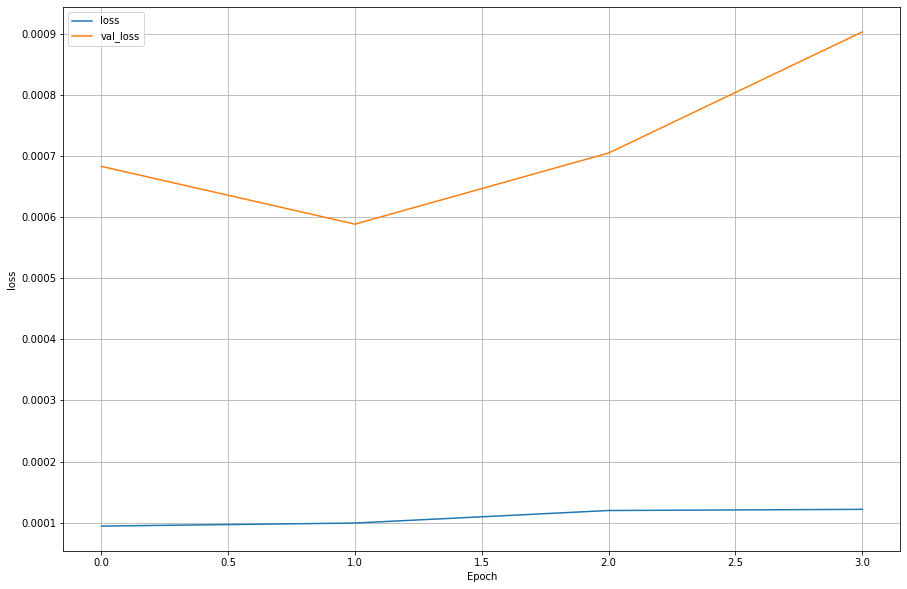

In [106]:
plot_loss(gru_bidi_loaded.history, 'loss')

In [107]:
gru_bidi_loaded.eval_mod(wide_window_d.test, 0)

Loss: 0.0002957872347906232 MAE: 0.01110122725367546


In [ ]:
gru_bidi_loaded.save_model("gru_bidi")

In [ ]:
retrain_model(self, patience, epochs, window):

In [ ]:
res = model_loaded.evaluate(wide_window_my.train)

In [ ]:
model_loaded = load_model("models_first\\gru_bidi.model")


In [ ]:
model_loaded.evaluate(wide_window_d.test)

In [ ]:
res[1]

## Single shots model
The entire sequence prediction in a single step.

24 min to the future with 2 min to the future

In [156]:
OUT_STEPS = 1
wide_window_d_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=['BTC-USD_close'])

wide_window_my_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=['BTC-USD_close'])



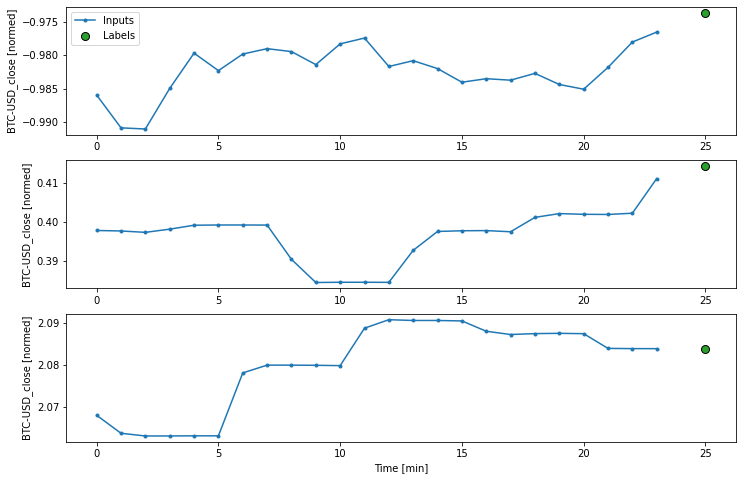

In [157]:
wide_window_my_single.plot()

In [158]:
single_val_performance = {}
single_performance = {}

### LSTM single shot

In [159]:
"""
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
   # tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
"""

'\nmulti_lstm_model = tf.keras.Sequential([\n    # Shape [batch, time, features] => [batch, lstm_units]\n    # Adding more `lstm_units` just overfits more quickly.\n    tf.keras.layers.LSTM(32, return_sequences=False),\n    # Shape => [batch, out_steps*features]\n    tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros),\n    # Shape => [batch, out_steps, features]\n   # tf.keras.layers.Reshape([OUT_STEPS, num_features])\n])\n'

In [160]:
lstm_model_single = tf.keras.Sequential([
    
    tf.keras.layers.LSTM(128,  return_sequences=True, activation="relu"),
    tf.keras.layers.LSTM(256,  return_sequences=True, activation="relu"),
    tf.keras.layers.LSTM(128, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
    
])

In [161]:
history = compile_and_fit(lstm_model_single, wide_window_d_single)

Epoch 1/20
1469/1469 [==============================] - 178s 121ms/step - loss: 0.0108 - mean_absolute_error: 0.0428 - val_loss: 0.0048 - val_mean_absolute_error: 0.0470
Epoch 2/20
1469/1469 [==============================] - 171s 116ms/step - loss: 0.0020 - mean_absolute_error: 0.0289 - val_loss: 0.0052 - val_mean_absolute_error: 0.0550
Epoch 3/20
1469/1469 [==============================] - 173s 117ms/step - loss: 0.0014 - mean_absolute_error: 0.0239 - val_loss: 0.0022 - val_mean_absolute_error: 0.0335
Epoch 4/20
1469/1469 [==============================] - 168s 114ms/step - loss: 0.0011 - mean_absolute_error: 0.0205 - val_loss: 0.0025 - val_mean_absolute_error: 0.0377
Epoch 5/20
1469/1469 [==============================] - 170s 116ms/step - loss: 9.5073e-04 - mean_absolute_error: 0.0196 - val_loss: 0.0030 - val_mean_absolute_error: 0.0416
Epoch 6/20
1469/1469 [==============================] - 169s 115ms/step - loss: 7.9272e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0018 - val_

In [162]:
single_val_performance['LSTM_single'] = lstm_model_single.evaluate(wide_window_d_single.val)
single_performance['LSTM_single'] = lstm_model_single.evaluate(wide_window_d_single.test, verbose=0)

420/420 [==============================] - 17s 41ms/step - loss: 0.0014 - mean_absolute_error: 0.0227


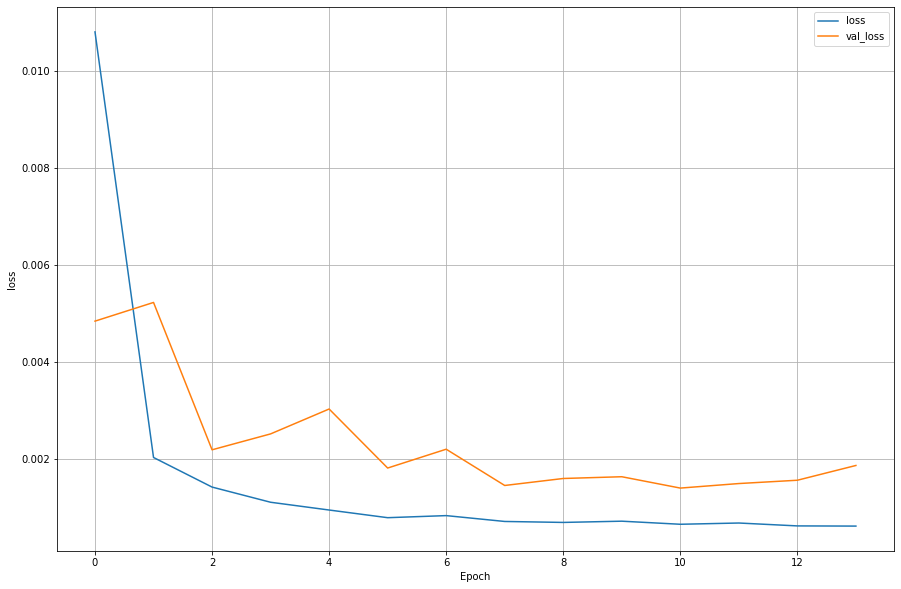

In [163]:
plot_loss(history, 'loss')

In [168]:
save_model(gru_model_single_shot, "lstm_single")

INFO:tensorflow:Assets written to: models_first\lstm_single.model\assets


### LSTM Bidirectional single shot

In [171]:
lstm_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="relu")),
    tf.keras.layers.Dense(32, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [172]:
history = compile_and_fit(lstm_model_bidirectional_single, wide_window_d_single)

Epoch 1/20
1469/1469 [==============================] - 375s 256ms/step - loss: 0.0093 - mean_absolute_error: 0.0392 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409
Epoch 2/20
1469/1469 [==============================] - 360s 245ms/step - loss: 0.0015 - mean_absolute_error: 0.0246 - val_loss: 0.0027 - val_mean_absolute_error: 0.0351
Epoch 3/20
1469/1469 [==============================] - 362s 247ms/step - loss: 0.0013 - mean_absolute_error: 0.0230 - val_loss: 0.0021 - val_mean_absolute_error: 0.0308
Epoch 4/20
1469/1469 [==============================] - 362s 247ms/step - loss: 0.0011 - mean_absolute_error: 0.0209 - val_loss: 0.0015 - val_mean_absolute_error: 0.0276
Epoch 5/20
1469/1469 [==============================] - 364s 248ms/step - loss: 9.5552e-04 - mean_absolute_error: 0.0199 - val_loss: 0.0016 - val_mean_absolute_error: 0.0275
Epoch 6/20
1469/1469 [==============================] - 362s 247ms/step - loss: 8.2499e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0014 - val_

In [173]:
single_val_performance['LSTM_bidi_single'] = lstm_model_bidirectional_single.evaluate(wide_window_d_single.val)
single_performance['LSTM_bidi_single'] = lstm_model_bidirectional_single.evaluate(wide_window_d_single.test, verbose=0)

420/420 [==============================] - 38s 90ms/step - loss: 0.0014 - mean_absolute_error: 0.0244 1s - loss: 0.0014 - mean_absolut


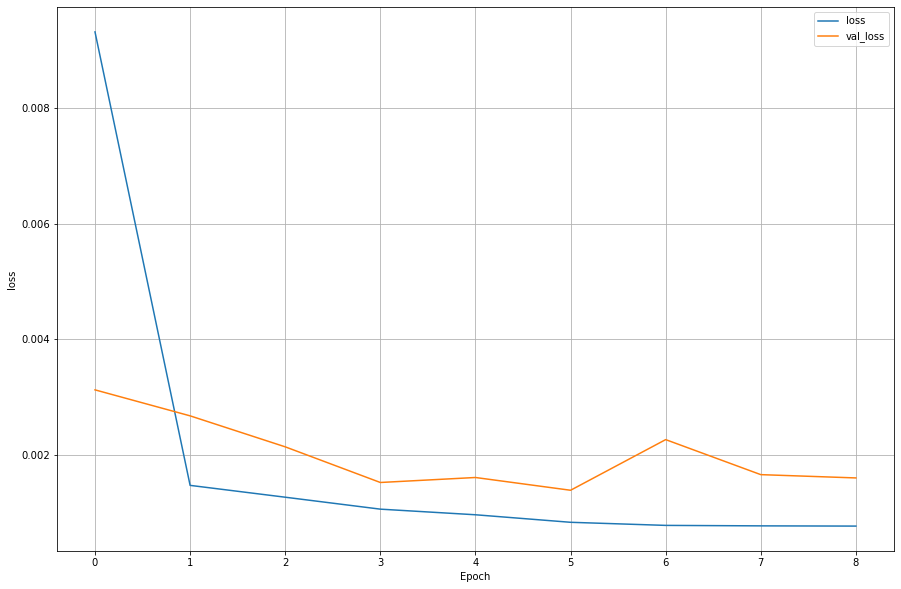

In [174]:
plot_loss(history, 'loss')

In [175]:
save_model(lstm_model_bidirectional_single, "lstm_bidi_single")

INFO:tensorflow:Assets written to: models_first\lstm_bidi_single.model\assets


### GRU single shot

In [176]:
gru_model_single_shot = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(128,  return_sequences=True, activation="relu"),
    tf.keras.layers.GRU(256,  return_sequences=True, activation="relu"),
    tf.keras.layers.GRU(128, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
    
])


In [177]:
history = compile_and_fit(gru_model_single_shot, wide_window_d_single)

Epoch 1/20
1469/1469 [==============================] - 129s 88ms/step - loss: 0.0057 - mean_absolute_error: 0.0299 - val_loss: 0.0018 - val_mean_absolute_error: 0.0318
Epoch 2/20
1469/1469 [==============================] - 138s 94ms/step - loss: 9.8447e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0021 - val_mean_absolute_error: 0.0327
Epoch 3/20
1469/1469 [==============================] - 137s 93ms/step - loss: 9.2818e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0012 - val_mean_absolute_error: 0.0254
Epoch 4/20
1469/1469 [==============================] - 137s 93ms/step - loss: 8.6513e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0022 - val_mean_absolute_error: 0.0332
Epoch 5/20
1469/1469 [==============================] - 137s 93ms/step - loss: 7.5453e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0019 - val_mean_absolute_error: 0.0316
Epoch 6/20
1469/1469 [==============================] - 137s 93ms/step - loss: 7.9683e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0013 

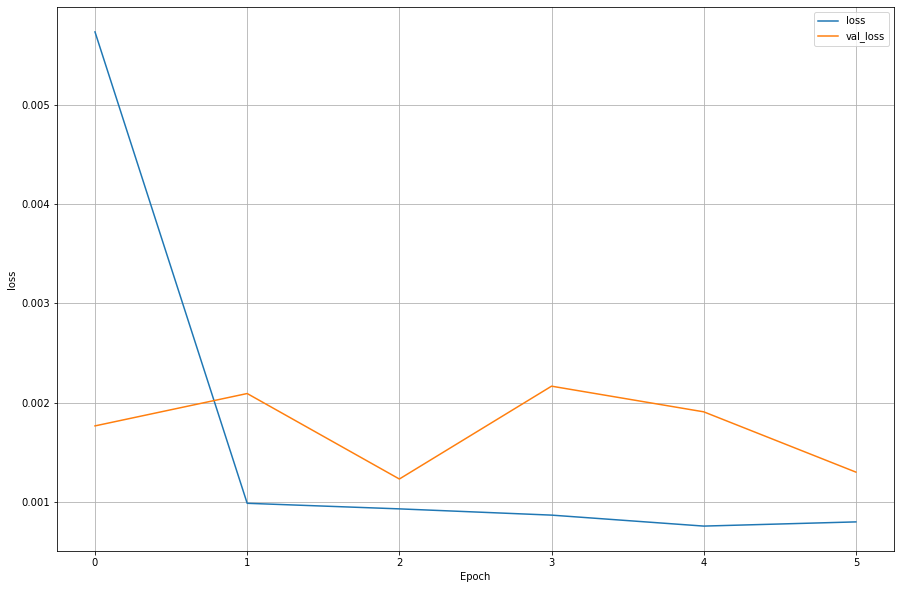

In [178]:
plot_loss(history, 'loss')

In [179]:
single_val_performance['GRU_single'] = gru_model_single_shot.evaluate(wide_window_d_single.val)
single_performance['GRU_single'] = gru_model_single_shot.evaluate(wide_window_d_single.test, verbose=0)

420/420 [==============================] - 15s 35ms/step - loss: 0.0012 - mean_absolute_error: 0.0254


In [180]:
save_model(gru_model_single_shot, "gru_single")

INFO:tensorflow:Assets written to: models_first\gru_single.model\assets


### GRU Bidirectional single shot

In [181]:
gru_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation="relu")),
    tf.keras.layers.Dense(32, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [182]:
history = compile_and_fit(gru_model_bidirectional_single, wide_window_d_single)

Epoch 1/20
1469/1469 [==============================] - 336s 229ms/step - loss: 0.0053 - mean_absolute_error: 0.0324 - val_loss: 0.0023 - val_mean_absolute_error: 0.0330
Epoch 2/20
1469/1469 [==============================] - 332s 226ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0023 - val_mean_absolute_error: 0.0372
Epoch 3/20
1469/1469 [==============================] - 332s 226ms/step - loss: 0.0011 - mean_absolute_error: 0.0208 - val_loss: 0.0016 - val_mean_absolute_error: 0.0287
Epoch 4/20
1469/1469 [==============================] - 331s 225ms/step - loss: 9.2363e-04 - mean_absolute_error: 0.0196 - val_loss: 0.0015 - val_mean_absolute_error: 0.0257
Epoch 5/20
1469/1469 [==============================] - 331s 225ms/step - loss: 8.4604e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0016 - val_mean_absolute_error: 0.0291
Epoch 6/20
1469/1469 [==============================] - 330s 225ms/step - loss: 7.5377e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0013 - 

In [183]:
single_val_performance['GRU_bidi_single'] = gru_model_bidirectional_single.evaluate(wide_window_d_single.val)
single_performance['GRU_bidi_single'] = gru_model_bidirectional_single.evaluate(wide_window_d_single.test, verbose=0)

420/420 [==============================] - 44s 105ms/step - loss: 0.0013 - mean_absolute_error: 0.0240


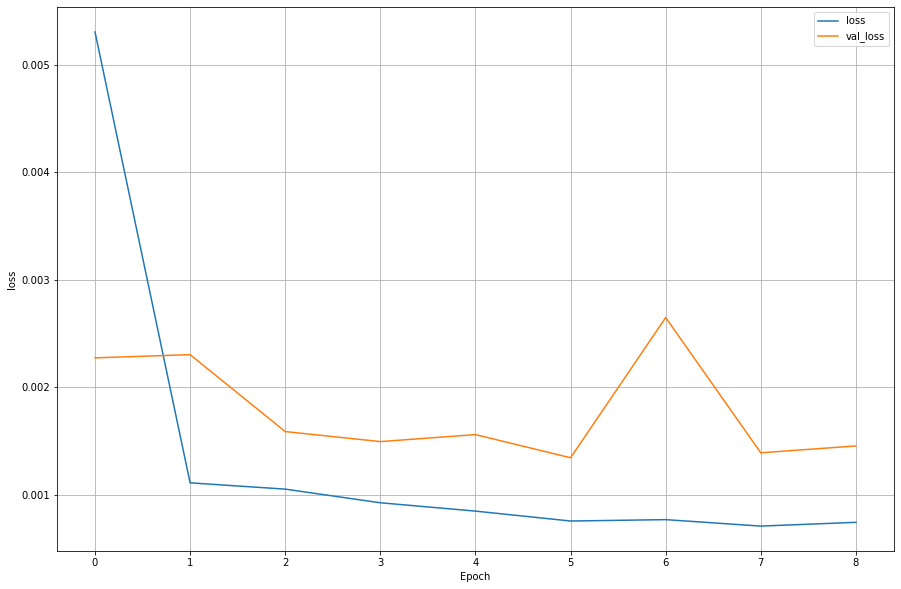

In [184]:
plot_loss(history, 'loss')

In [185]:
save_model(gru_model_bidirectional_single, "gru_bidi_single")

INFO:tensorflow:Assets written to: models_first\gru_bidi_single.model\assets


### Autoregressive model

In [186]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [187]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [188]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [189]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

NameError: name 'multi_window' is not defined

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

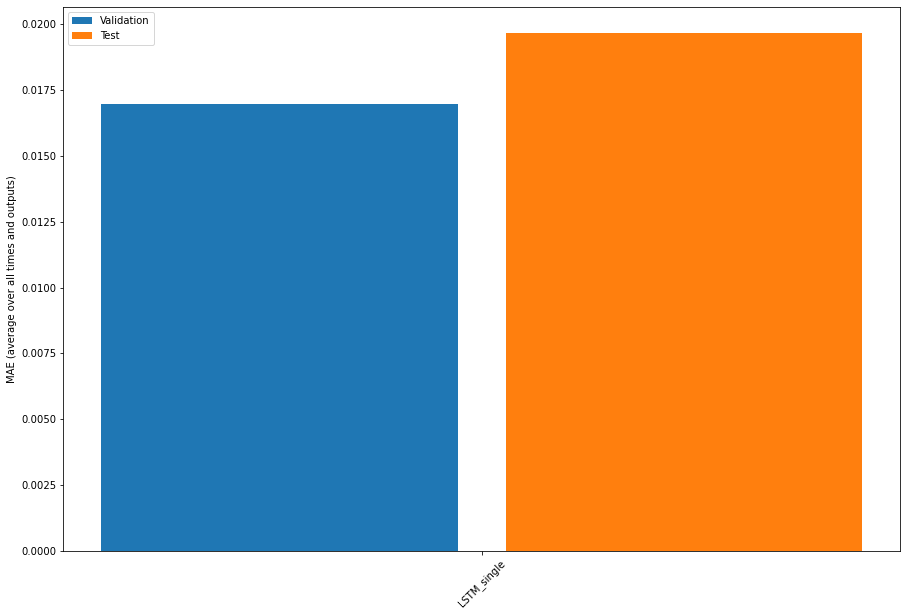

In [192]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model_single.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()